# Approximate inference

_Author: Christoph Rahmede_

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1">Load the data</a></span></li><li><span><a href="#Sklearn-logistic-regression" data-toc-modified-id="Sklearn-logistic-regression-2">Sklearn logistic regression</a></span></li><li><span><a href="#Bayesian-logistic-regression" data-toc-modified-id="Bayesian-logistic-regression-3">Bayesian logistic regression</a></span><ul class="toc-item"><li><span><a href="#Run-the-model-with-MCMC" data-toc-modified-id="Run-the-model-with-MCMC-3.1">Run the model with MCMC</a></span></li><li><span><a href="#Run-the-model-with-ADVI" data-toc-modified-id="Run-the-model-with-ADVI-3.2">Run the model with ADVI</a></span></li></ul></li></ul></div>

One of the main drawbacks of Bayesian modeling is surely the huge amount of computational resources required. For this reason, other methods having been invented to estimate the posterior. 

A computationally less intensive method which works also with larger datasets is based on variational inference. The posterior distribution is approximated by a simpler type of distribution and the distance between them is minimized. A simpler approximation is for example obtained by assuming independence of all model parameters.

This approach turns finding the posterior into an optimization problem. Pymc3 includes a variety of methods for this purpose, for example Automatic Differentiation Variational Inference (ADVI).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

## Load the data

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()
X = data.data
y = data.target

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

## Sklearn logistic regression

In [4]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs',multi_class='ovr')
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.925

## Bayesian logistic regression

In [5]:
import pymc3 as pm
import theano.tensor as tt
import theano

In [6]:
with pm.Model() as model:

    beta = pm.Normal('beta', 0, sd=10, shape=(4, 3))
    intercept = pm.Normal('intercept',0, 2, shape=(3,))
    p = tt.nnet.softmax(intercept+pm.math.dot(X, beta))

    observed = pm.Categorical('likelihood', p=p, observed=y)

### Run the model with MCMC

In [7]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:27<00:00, 215.58draws/s]


In [8]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0_0,-2.124317,7.272132,0.150982,-16.665764,12.094179,2527.680920,1.000178
beta__0_1,1.484007,6.290423,0.122191,-10.523066,13.715218,2102.226497,1.000538
beta__0_2,0.178166,6.297087,0.118827,-12.097905,12.024375,2154.206011,1.000400
beta__1_0,6.065159,6.743196,0.136382,-6.819849,19.579921,2053.864031,0.999769
beta__1_1,-2.517414,6.043965,0.136085,-14.410382,9.294979,1761.670826,0.999746
beta__1_2,-3.409441,6.053902,0.136015,-15.343738,8.596415,1784.538696,0.999893
beta__2_0,-9.293224,8.290279,0.130314,-24.982897,6.912047,3383.564249,1.000739
beta__2_1,0.876213,6.592304,0.138774,-11.755959,13.559725,2028.531705,0.999999
beta__2_2,8.367732,6.686303,0.143823,-4.695897,21.081081,1941.930302,0.999954
beta__3_0,-8.498151,8.405383,0.160949,-24.020410,8.225631,3162.001635,1.000625


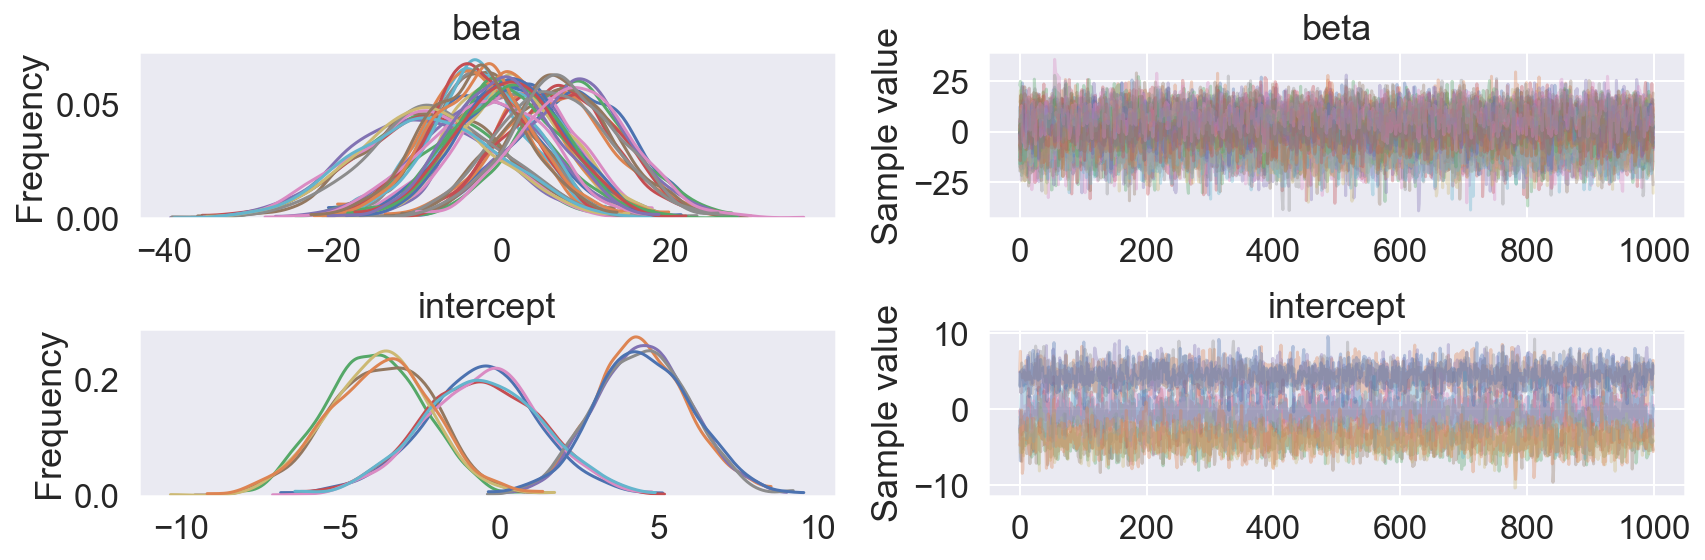

In [9]:
pm.traceplot(trace)
plt.show()

In [10]:
from scipy.stats import mode

In [11]:
trace_ppc = pm.sample_posterior_predictive(trace,1000,model=model)['likelihood']
trace_predictions = mode(trace_ppc,axis=0).mode.ravel()
np.mean(y==trace_predictions)

100%|██████████| 1000/1000 [00:10<00:00, 94.75it/s]


0.9733333333333334

### Run the model with ADVI

First we perform a fit, choosing any of the available methods. 

In [12]:
with model:
    approx = pm.fit(15000, method='advi')

Average Loss = 60.303: 100%|██████████| 15000/15000 [00:10<00:00, 1498.50it/s]
Finished [100%]: Average Loss = 60.294


We can check for convergence (of the so-called evidence lower bound).

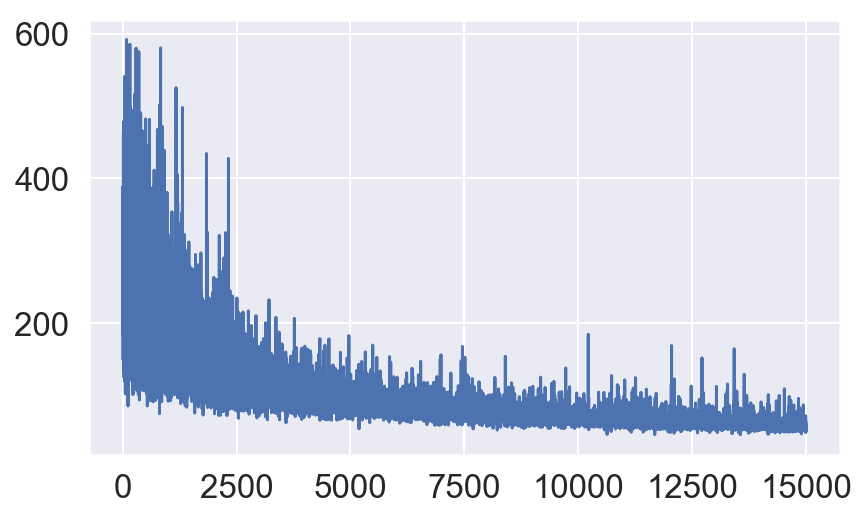

In [13]:
plt.plot(approx.hist)
plt.show()

We can use the approximation to obtain sample representing the posterior in the same way as a trace:

In [14]:
trace_approx = pm.sample_approx(approx, draws=1000)

In [15]:
trace_approx

<MultiTrace: 1 chains, 1000 iterations, 2 variables>

In [16]:
pm.summary(trace_approx)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta__0_0,-1.797121,1.086314,0.028907,-3.785846,0.445029
beta__0_1,0.523046,0.395277,0.014243,-0.253466,1.274685
beta__0_2,0.489303,0.424142,0.013381,-0.377691,1.265721
beta__1_0,2.173535,0.941322,0.028392,0.238152,3.979269
beta__1_1,-0.706427,0.388848,0.012045,-1.450719,0.036601
beta__1_2,-0.672028,0.420384,0.013465,-1.413429,0.208675
beta__2_0,-3.113749,1.256304,0.040318,-5.684070,-0.797210
beta__2_1,-0.139009,0.468414,0.012540,-1.094828,0.751398
beta__2_2,1.786024,0.468942,0.013630,0.890692,2.706635
beta__3_0,-3.115370,1.272582,0.039687,-5.513451,-0.572251


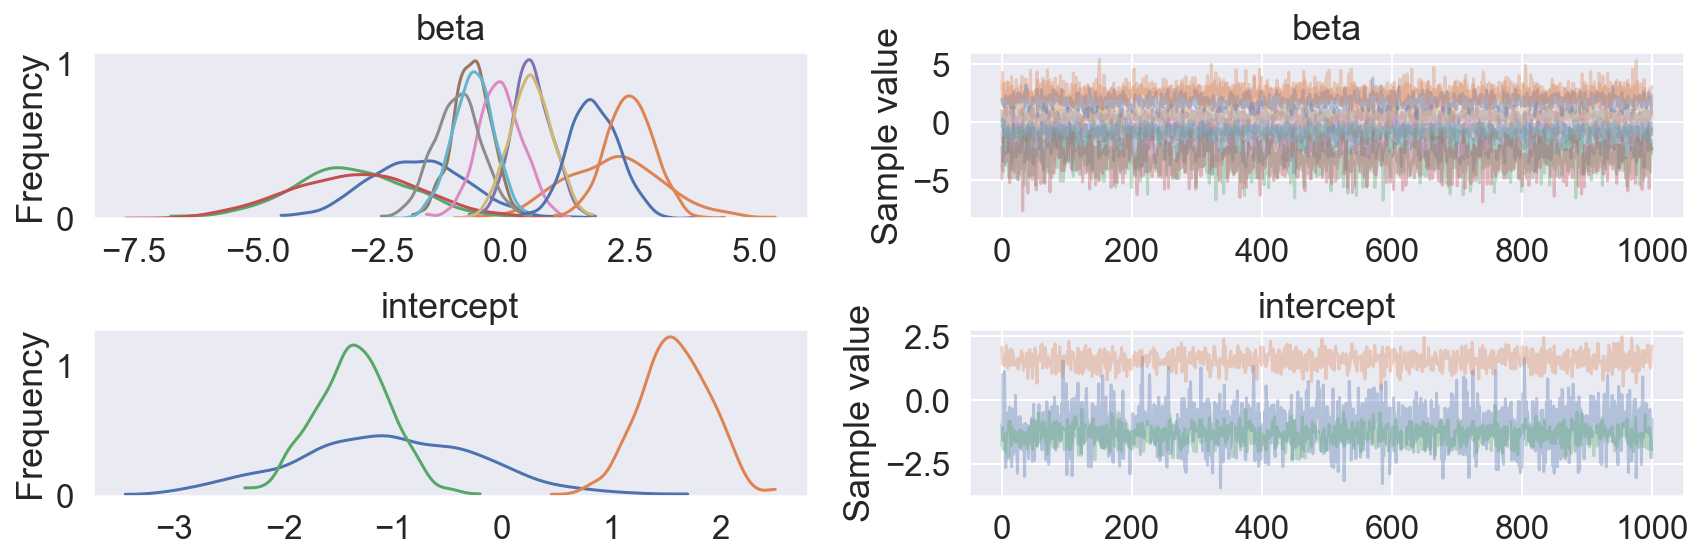

In [17]:
pm.traceplot(trace_approx)
plt.show()

In [18]:
approx_ppc = pm.sample_posterior_predictive(trace_approx,1000,model=model)['likelihood']
approx_predictions = mode(approx_ppc,axis=0).mode.ravel()
np.mean(y==approx_predictions)

100%|██████████| 1000/1000 [00:12<00:00, 77.01it/s]


0.96